In [ ]:
# Copyright (c) 2025 Advanced Micro Devices, Inc. All rights reserved This software is distributed under the MIT License, Contact: Alessandro Fanfarillo

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
class PINNProjectileMultiAngle(nn.Module):
    def __init__(self, hidden_units=32, hidden_layers=2):
        """
        A small MLP that takes (t, angle) and outputs (x(t, angle), y(t, angle)).
        """
        super().__init__()
        
        layers = []
        input_dim = 2  # [t, angle]
        output_dim = 2 # [x, y]

        # First layer
        layers.append(nn.Linear(input_dim, hidden_units))
        layers.append(nn.Tanh())

        # Hidden layers
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_units, hidden_units))
            layers.append(nn.Tanh())

        # Output layer
        layers.append(nn.Linear(hidden_units, output_dim))

        self.network = nn.Sequential(*layers)

    def forward(self, inputs):
        """
        Forward pass: inputs shape [N, 2] => columns are [t, angle].
        Output shape [N, 2] => [ x, y ].
        """
        return self.network(inputs)

In [3]:
def compute_pde_loss_multi_angle(model, t_collocation, angles_collocation, g=9.81):
    """
    PDE Loss for multiple angles simultaneously.

    We want:
      d^2x/dt^2 = 0   and   d^2y/dt^2 = -g

    Inputs:
      model: the PINN model, NN(t, angle) -> (x, y)
      t_collocation: shape [N, 1]
      angles_collocation: shape [N, 1]
    """
    # We need gradients w.r.t t, so ensure `requires_grad=True`
    t_collocation.requires_grad_(True)

    # Combine (t, angle) into single input [N,2]
    in_tensor = torch.cat([t_collocation, angles_collocation], dim=1)  # shape [N,2]

    # Forward pass:  [N,2] -> [N,2]
    xy = model(in_tensor)
    x = xy[:, 0:1]  # [N,1]
    y = xy[:, 1:2]  # [N,1]

    # First derivatives:  dx/dt, dy/dt
    x_t = torch.autograd.grad(
        x, t_collocation,
        grad_outputs=torch.ones_like(x),
        create_graph=True
    )[0]

    y_t = torch.autograd.grad(
        y, t_collocation,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]

    # Second derivatives:  d^2x/dt^2, d^2y/dt^2
    x_tt = torch.autograd.grad(
        x_t, t_collocation,
        grad_outputs=torch.ones_like(x_t),
        create_graph=True
    )[0]

    y_tt = torch.autograd.grad(
        y_t, t_collocation,
        grad_outputs=torch.ones_like(y_t),
        create_graph=True
    )[0]

    # Enforce PDE
    #  We want x_tt = 0 and y_tt = -g
    loss_x = torch.mean((x_tt - 0.0)**2)
    loss_y = torch.mean((y_tt + g)**2)
    return loss_x + loss_y

In [4]:
def compute_bc_loss_multi_angle(model, angles, v0=10.0, g=9.81, device='cuda'):

    angles_rad = np.radians(angles.detach().cpu().numpy())
    angles_rad_torch = torch.tensor(angles_rad, dtype=torch.float32, requires_grad=False)
    
    # Create an input of shape [N,2] => [ (0, angle_i) for i in range(N) ]
    N = angles.shape[0]
    t0 = torch.zeros_like(angles)  # shape [N,1] of zeros
    in_tensor = torch.cat([t0, angles], dim=1)  # shape [N,2]
    in_tensor = in_tensor.requires_grad_(True)

    # Forward pass
    xy0 = model(in_tensor)  # shape [N,2]
    x0 = xy0[:, 0:1]
    y0 = xy0[:, 1:2]

    # We need derivatives wrt t at t=0
    x_t0 = torch.autograd.grad(
        x0, in_tensor,
        grad_outputs=torch.ones_like(x0),
        create_graph=True
    )[0]  # shape [N,2] => partial derivatives wrt [t, angle]

    y_t0 = torch.autograd.grad(
        y0, in_tensor,
        grad_outputs=torch.ones_like(y0),
        create_graph=True
    )[0]  # shape [N,2]

    # Partial derivative wrt t is x_t0[:,0], y_t0[:,0]
    # Partial derivative wrt angle is x_t0[:,1]
    x_t0_wrt_t = x_t0[:, 0:1]
    y_t0_wrt_t = y_t0[:, 0:1]

    # Target velocities
    vx0 = v0 * np.cos(angles_rad)
    vy0 = v0 * np.sin(angles_rad)
    vx0_torch = torch.tensor(vx0, dtype=torch.float32).view(-1,1).to(device)
    vy0_torch = torch.tensor(vy0, dtype=torch.float32).view(-1,1).to(device)

    # MSE losses
    loss_x0 = torch.mean((x0 - 0.0)**2)
    loss_y0 = torch.mean((y0 - 0.0)**2)
    loss_vx0 = torch.mean((x_t0_wrt_t - vx0_torch)**2)
    loss_vy0 = torch.mean((y_t0_wrt_t - vy0_torch)**2)

    bc_loss = loss_x0 + loss_y0 + loss_vx0 + loss_vy0
    return bc_loss

In [5]:
def train_pinn_multiple_angles(model,
                               v0=10.0,
                               angle_min=15.0,
                               angle_max=75.0,
                               n_angles=50,
                               collocation_points=50,
                               epochs=5000,
                               lr=1e-3,
                               g=9.81):
    """
    Steps:
      1. Create a set of angles in degrees. e.g. np.linspace(angle_min, angle_max, n_angles)
      2. For each angle, compute T(angle)=2*v0*sin(angle_rad)/g
      3. Sample collocation_points in [0, T(angle)]
      4. Enforce PDE + BC for all angles/times
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 1) Angles array
    angles_deg = np.linspace(angle_min, angle_max, n_angles, dtype=np.float32)

    # We'll build a big "collocation set" of (t, angle_deg) pairs
    all_t = []
    all_angles = []

    for angle in angles_deg:
        angle_rad = np.radians(angle)
        T = 2.0 * v0 * np.sin(angle_rad) / g

        # Times in [0, T]
        t_vals = np.linspace(0, T, collocation_points, dtype=np.float32)

        # Expand each t with the same angle
        angle_arr = np.full_like(t_vals, angle, dtype=np.float32)

        all_t.append(t_vals)
        all_angles.append(angle_arr)

    # Stack them into single arrays
    all_t = np.concatenate(all_t, axis=0)        # shape [n_angles * collocation_points]
    all_angles = np.concatenate(all_angles, axis=0) # same shape

    # Convert to torch
    t_collocation = torch.tensor(all_t, dtype=torch.float32).view(-1,1).to(device)
    angle_collocation = torch.tensor(all_angles, dtype=torch.float32).view(-1,1).to(device)

    # We'll also keep the angles separate for boundary conditions
    # We want to enforce BC for each angle. We'll just replicate them individually.
    bc_angles = torch.tensor(angles_deg, dtype=torch.float32).view(-1,1).to(device)

    # 2) Setup optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # 3) Training loop
    for epoch in range(epochs):
        optimizer.zero_grad()

        # PDE loss over all collocation points (multiple angles)
        loss_pde = compute_pde_loss_multi_angle(model, t_collocation, angle_collocation, g=g)

        # BC loss for all angles
        loss_bc = compute_bc_loss_multi_angle(model, bc_angles, v0=v0, g=g, device=device)

        loss = loss_pde + loss_bc
        loss.backward()
        optimizer.step()

        if (epoch+1) % 500 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] | Total Loss={loss.item():.6e} "
                  f"(PDE={loss_pde.item():.6e}, BC={loss_bc.item():.6e})")

In [6]:
model = PINNProjectileMultiAngle(hidden_units=256, hidden_layers=6)

# Train on angles in [15, 75] with v0=10 m/s
train_pinn_multiple_angles(
    model,
    v0=10.0,
    angle_min=15.0,
    angle_max=65.0,
    n_angles=200,
    collocation_points=100,
    epochs=2000,
    lr=1e-3,
    g=9.81)

Epoch [500/2000] | Total Loss=1.395629e-01 (PDE=6.758374e-02, BC=7.197916e-02)
Epoch [1000/2000] | Total Loss=1.558118e-01 (PDE=4.522781e-02, BC=1.105840e-01)
Epoch [1500/2000] | Total Loss=2.342712e+01 (PDE=7.338183e+00, BC=1.608894e+01)
Epoch [2000/2000] | Total Loss=1.287713e-01 (PDE=5.083106e-02, BC=7.794023e-02)


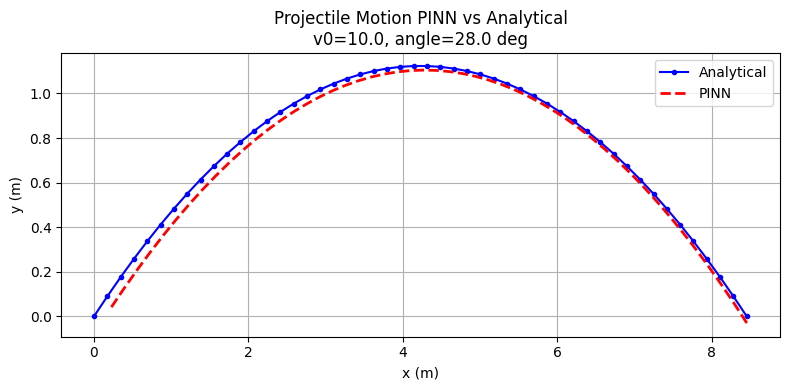

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
angle_test = 28.0
v0=10.0
angle_test_rad = np.radians(angle_test)
T_test = 2.0 * 10.0 * np.sin(angle_test_rad) / 9.81
t_vals = np.linspace(0, T_test, 50, dtype=np.float32)
angle_arr = np.full_like(t_vals, angle_test, dtype=np.float32)

# Prepare input for the model
input_test = torch.tensor(np.column_stack([t_vals, angle_arr]), dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
   xy_pred = model(input_test).cpu().numpy()

x_pred = xy_pred[:, 0]
y_pred = xy_pred[:, 1]
#Compare with the exact formula: x(t)=v0 cos(angle)*t, y(t)=...
x_true = 10.0*np.cos(angle_test_rad)*t_vals
y_true = 10.0*np.sin(angle_test_rad)*t_vals - 0.5*9.81*t_vals**2

# Plot
plt.figure(figsize=(8,4))
plt.plot(x_true, y_true, 'b-o', label='Analytical', markersize=3)
plt.plot(x_pred, y_pred, 'r--', label='PINN', linewidth=2)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(f"Projectile Motion PINN vs Analytical\nv0={v0}, angle={angle_test} deg")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

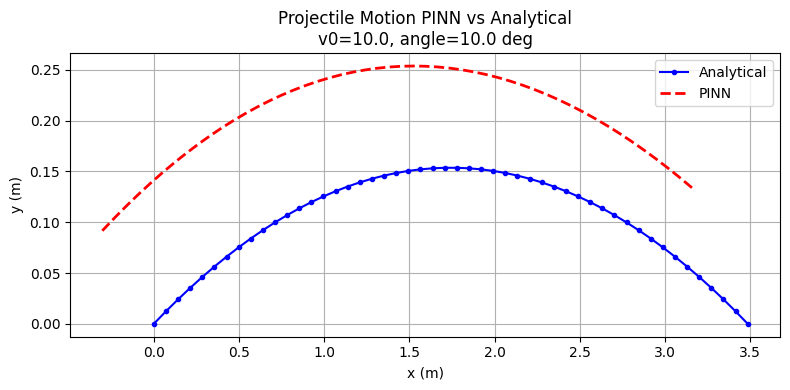

In [10]:
angle_test = 10.0
v0=10.0
angle_test_rad = np.radians(angle_test)
T_test = 2.0 * 10.0 * np.sin(angle_test_rad) / 9.81
t_vals = np.linspace(0, T_test, 50, dtype=np.float32)
angle_arr = np.full_like(t_vals, angle_test, dtype=np.float32)

# Prepare input for the model
input_test = torch.tensor(np.column_stack([t_vals, angle_arr]), dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
   xy_pred = model(input_test).cpu().numpy()

x_pred = xy_pred[:, 0]
y_pred = xy_pred[:, 1]
#Compare with the exact formula: x(t)=v0 cos(angle)*t, y(t)=...
x_true = 10.0*np.cos(angle_test_rad)*t_vals
y_true = 10.0*np.sin(angle_test_rad)*t_vals - 0.5*9.81*t_vals**2

# Plot
plt.figure(figsize=(8,4))
plt.plot(x_true, y_true, 'b-o', label='Analytical', markersize=3)
plt.plot(x_pred, y_pred, 'r--', label='PINN', linewidth=2)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(f"Projectile Motion PINN vs Analytical\nv0={v0}, angle={angle_test} deg")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()